**
Importing libraries¶
**

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import pickle
import itertools

from datetime import datetime, date
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler

from math import ceil

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix
from keras.models import model_from_json


from tensorflow.python.keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split


from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
%matplotlib inline

# Any results you write to the current dire~ctory are saved as output.|

In [63]:

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


**1. Starting with Kaggle - importing data**

In [64]:
sample_submission = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")
train = pd.read_csv("../input/digit-recognizer/train.csv")
print("Provided training dataset is of size:{}\n Test dataset is of size:{}".format(train.shape,test.shape))

Provided training dataset is of size:(42000, 785)
 Test dataset is of size:(28000, 784)


In [65]:
x_train = train.drop(['label'],axis=1)
y_train = train['label']

del train

 Check for null and missing values

In [66]:
x_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [67]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

There are no missing values. We can go ahead.

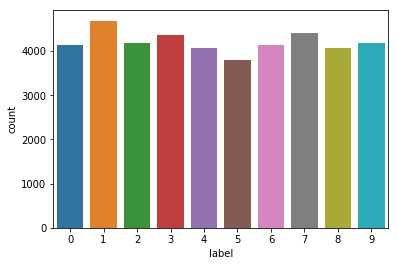

In [68]:
g = sns.countplot(y_train)


Thus,we have we have similar counts for all the 10 digits.


Next step is normalization and reshape

In [69]:
x_train = x_train.values.astype('float32') #all pixel values
y_train = y_train.values.astype('float32') #all target digits

x_test = test.values.astype('float32')
x_train = x_train/255.0
x_test = x_test/255.0
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)





In [70]:
#One hot encoding
print("Original shape of y_train: {}".format(y_train.shape))
y_train = to_categorical(y_train, num_classes = 10)
print("Shape after one hot encoding: {}".format(y_train_ohe.shape))

Original shape of y_train: (42000,)
Shape after one hot encoding: (42000, 10)


In [71]:
#splitting into test and rest
x_rest, x_test, y_rest, y_test = train_test_split(x_train, y_train, test_size = 0.2, random_state=42)
#splitting into train and val
x_train, x_val, y_train, y_val = train_test_split(x_rest, y_rest, test_size = 0.2, random_state=42)

print("Shape of training data sets:{}".format(x_train.shape))
print("Shape of validation data sets:{}".format(x_val.shape))
print("Shape of test data sets:{}".format(x_test.shape))

Shape of training data sets:(26880, 28, 28, 1)
Shape of validation data sets:(6720, 28, 28, 1)
Shape of test data sets:(8400, 28, 28, 1)


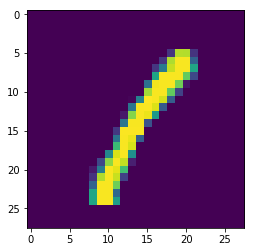

In [72]:
# Some examples
g = plt.imshow(x_train[np.random.randint(0,np.shape(x_train)[0]-1)][:,:,0])

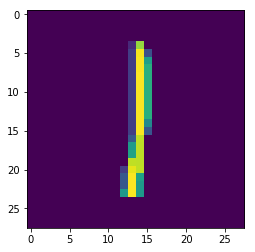

In [73]:
g = plt.imshow(x_train[np.random.randint(0,np.shape(x_train)[0]-1)][:,:,0])


Adding dimensions for keras¶
a 2D-Conv layer expects an input of shape

#examples
#pix row
#pix column
#channels


**Defining the architecture**

In [74]:
#build model
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(5,5),activation='relu',input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(5,5),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dense(10,activation='softmax'))
          
#compile model
          
model.compile(loss=categorical_crossentropy,optimizer=Adam(),metrics=['accuracy'])
#change the optimizer to RMSprop for better results
          
#print model summary
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        51264     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2360320   
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

#TODO ADD THE CODE : Use annealing method of the learning rate (LR) to make the optimizer converge faster and closest to the global minimum of the loss function.

#TODO: Data augmentation to improve the accuracy

In [75]:
### Fit the model
x_train.shape,y_train.shape,x_val.shape,y_val.shape
#history = model.fit(x_train,y_train,batch_size=64,epochs=20,verbose=2,validation_data=(x_val,y_val))
history = model.fit(x_train,y_train,batch_size=64,epochs=2,verbose=2,validation_data=(x_val,y_val))

Train on 26880 samples, validate on 6720 samples
Epoch 1/2
 - 31s - loss: 0.1727 - accuracy: 0.9438 - val_loss: 0.0609 - val_accuracy: 0.9817
Epoch 2/2
 - 32s - loss: 0.0510 - accuracy: 0.9842 - val_loss: 0.0432 - val_accuracy: 0.9869


In [ ]:
#saving history
with open('/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
#saving model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

##############################################################################################

In [ ]:

#history = json.load(open('/trainHistoryDict, 'r'))

Evaluate the model¶


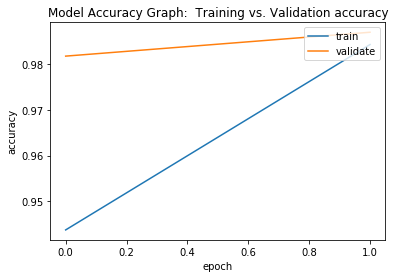

In [76]:
# plt.figure(1)
# plt.plot(history.history['val_loss'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Complexity Graph:  Training vs. Validation Loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validate'], loc='upper right')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Graph:  Training vs. Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [77]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion Matrix


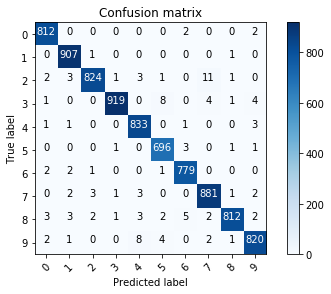

In [82]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict the values from the validation dataset
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1)

print('Confusion Matrix')

confusion_mtx = confusion_matrix(y_true,y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [83]:
#classification_report
print("Classification_report")
print(classification_report(y_true,y_pred_classes))


Classification_report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       816
           1       0.99      1.00      0.99       909
           2       0.99      0.97      0.98       846
           3       1.00      0.98      0.99       937
           4       0.98      0.99      0.99       839
           5       0.98      0.99      0.98       702
           6       0.99      0.99      0.99       785
           7       0.98      0.99      0.98       893
           8       0.99      0.97      0.98       835
           9       0.98      0.98      0.98       838

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400

